In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nilearn as nl
import nibabel as nib
import tarfile
import nilearn.plotting as nlplt
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [ ]:
pip install elasticdeform


In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> 3
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22

IMG_SIZE=128

In [ ]:
CHANELS = 2

In [ ]:
STATE= "AVG"

In [ ]:

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

In [ ]:


nSample = os.listdir('./sample_img')
nSample


['BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz']

In [ ]:

file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()


In [ ]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [ ]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t2.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz']

In [ ]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

Train

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)
input_layer = Input((IMG_SIZE, IMG_SIZE, CHANELS))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]



def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.1)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.1)

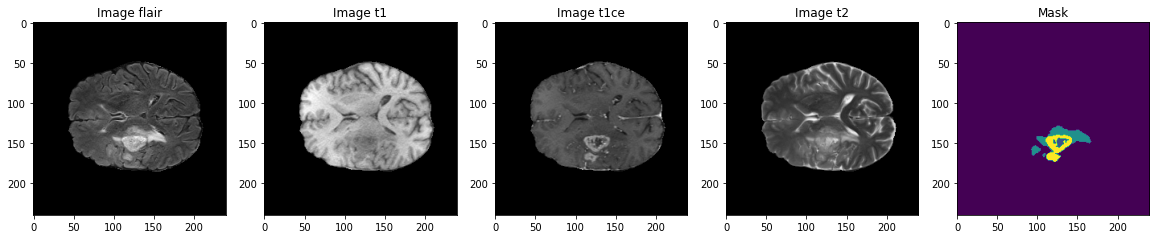

In [ ]:
case_index = 0
case_name = test_ids[case_index]

test_image_flair = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_flair.nii.gz')).get_fdata()
test_image_t1 = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t1.nii.gz')).get_fdata()
test_image_t1ce = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t1ce.nii.gz')).get_fdata()
test_image_t2 = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t2.nii.gz')).get_fdata()
test_mask = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_seg.nii.gz')).get_fdata()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
slice_w = test_image_flair.shape[2] // 2

axes[0].imshow(test_image_flair[:, :, slice_w], cmap='gray')
axes[0].set_title('Image flair')

axes[1].imshow(test_image_t1[:, :, slice_w], cmap='gray')
axes[1].set_title('Image t1')

axes[2].imshow(test_image_t1ce[:, :, slice_w], cmap='gray')
axes[2].set_title('Image t1ce')

axes[3].imshow(test_image_t2[:, :, slice_w], cmap='gray')
axes[3].set_title('Image t2')

axes[4].imshow(test_mask[:, :, slice_w])
axes[4].set_title('Mask')

plt.show()


In [ ]:
#Early fusion AVG of the 4 modalities

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 2, n_channels = CHANELS, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            t1_path = os.path.join(case_path, f'{i}_t1.nii.gz')
            t1 = nib.load(t1_path).get_fdata()

            t2_path = os.path.join(case_path, f'{i}_t2.nii.gz')
            t2 = nib.load(t2_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
            #average calculation
            avg = (ce + flair + t1+ t2)/4
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(avg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

In [ ]:
#Early fusion of 4 modalities or 2
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = CHANELS, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            t1_path = os.path.join(case_path, f'{i}_t1.nii.gz')
            t1 = nib.load(t1_path).get_fdata()

            t2_path = os.path.join(case_path, f'{i}_t2.nii.gz')
            t2 = nib.load(t2_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                #Choose two or 4 modalities or others
                #X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                #X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

In [ ]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

1012
126
113


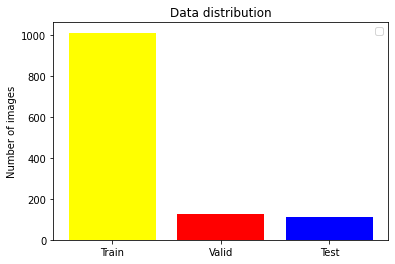

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'yellow','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

showDataLayout()

In [ ]:
 from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="2D-UNet-2024-weights-improvement-{epoch:02d}-{val_accuracy:.3f}_flair_t1ce.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2024_2D_UNet_15_flair_t1ce.log')

history =  model.fit(training_generator,
                    epochs=15,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )

In [ ]:
model.save("model_brats21_2D_UNet_2_modes.h5")

In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('model_brats21_2D_UNet_2_modes.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_2024_2D_UNet_15_flair_t1ce.log', sep=',', engine='python')

###########################
acc = history['accuracy']
val_acc = history['val_accuracy']

epoch = range(len(acc))

loss = history['loss']
val_loss = history['val_loss']

train_dice = history['dice_coef']
val_dice = history['val_dice_coef']

f, ax = plt.subplots(1, 3, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[2].legend()

plt.savefig('training_result_2018.png')
plt.show()


In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

In [ ]:
import os

#   TRAIN_DATASET_PATH is the path to your dataset directory
dataset_path = TRAIN_DATASET_PATH

# Get a list of files in the dataset directory
files = os.listdir(dataset_path)

# Extract case names from filenames
case_names = [file.split('_')[1] for file in files if 'flair.nii' in file]

# Print the case names
for case in case_names:
    print(case)


In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('/kaggle/working/model_brats21_2D_UNet_2_modes_t1_t2.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('/kaggle/working/model_brats21_2D_UNet_2_modes_t1_t2.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
def showPredictsByCaseName(case_name, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, case_name)

    # Construct file paths
    seg_path = os.path.join(path, f'{case_name}_seg.nii.gz')
    flair_path = os.path.join(path, f'{case_name}_flair.nii.gz')

    # Print file paths
    print(f'Segmentation path: {seg_path}')
    print(f'Flair image path: {flair_path}')

    # Check if the segmentation file exists
    if not os.path.exists(seg_path):
        print(f"Segmentation file not found for case {case_name}")
        # Print the contents of the directory
        print(f"Contents of {path}: {os.listdir(path)}")
        return  # This 'return' is part of the function

    try:
        # Load segmentation ground truth
        gt = nib.load(seg_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Segmentation file not found for case {case_name}")
        return  # This 'return' is part of the function

    try:
        # Load original image
        origImage = nib.load(flair_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Original image file not found for case {case_name}")
        return  # This 'return' is part of the function

    # The rest of your code for prediction and visualization

# Example usage for case 'BraTS2021_00131'
showPredictsByCaseName(case_name='BraTS2021_00131')


Segmentation path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_seg.nii.gz
Flair image path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_flair.nii.gz


In [ ]:
def showPredictsByCaseName(case_name, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, case_name)

    # Construct file paths
    seg_path = os.path.join(path, f'{case_name}_seg.nii.gz')
    flair_path = os.path.join(path, f'{case_name}_flair.nii')

    # Print file paths
    print(f'Segmentation path: {seg_path}')
    print(f'Flair image path: {flair_path}')

    # Check if the segmentation file exists
    if not os.path.exists(seg_path):
        print(f"Segmentation file not found for case {case_name}")
        # Print the contents of the directory
        print(f"Contents of {path}: {os.listdir(path)}")
        return

    try:
        # Load segmentation ground truth
        gt = nib.load(seg_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Segmentation file not found for case {case_name}")
        return

    try:
        # Load original image
        origImage = nib.load(flair_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Original image file not found for case {case_name}")
        return

    # Your existing code for prediction
    p = predictByPath(path, case_name)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Display images
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 7, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].set_title('Original image flair')

    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} predicted')

    # Display the predicted mask overlay on the original image
    axarr[6].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                    cmap="gray", interpolation='none')
    axarr[6].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[6].set_title('Overlay: Prediction on Original Image')

    plt.savefig(f'Test_{case_name}.png')
    plt.show()

# Example usage for case 'BraTS2021_00131'
showPredictsByCaseName(case_name='BraTS2021_00131')


Segmentation path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_seg.nii.gz
Flair image path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_flair.nii
Error: Original image file not found for case BraTS2021_00131


In [ ]:
#Display detailed classes
def showPredictsById(case, start_slice=60):
    path = TRAIN_DATASET_PATH + case + '/'

    gt = nib.load(path + case + '_seg.nii.gz').get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray", interpolation='none')
    axes[0, 0].set_title('Original image flair')

    axes[0, 1].imshow(cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST),
                        cmap="Reds", interpolation='none', alpha=0.3)
    axes[0, 1].set_title('Ground truth')

    axes[0, 2].imshow(p[start_slice, :, :, 1:4], cmap="plasma", interpolation='none', alpha=0.3)
    axes[0, 2].set_title('All Classes')

    axes[1, 0].imshow(edema[start_slice, :, :], cmap="viridis", interpolation='none', alpha=0.3)
    axes[1, 0].set_title(f'{SEGMENT_CLASSES[1]} Predicted')

    axes[1, 1].imshow(core[start_slice, :, :], cmap="inferno", interpolation='none', alpha=0.3)
    axes[1, 1].set_title(f'{SEGMENT_CLASSES[2]} Predicted')

    axes[1, 2].imshow(enhancing[start_slice, :, :], cmap="magma", interpolation='none', alpha=0.3)
    axes[1, 2].set_title(f'{SEGMENT_CLASSES[3]} Predicted')

    plt.tight_layout()
    plt.savefig(f'Test_{case}.png')
    plt.show()


In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('/kaggle/input/m4/keras/m4/1/3D-UNet-2018-weights-improvement-11-0.993_flair_t1ce.hdf5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii.gz')
    print(f'Flair image path: {vol_path_flair}')

    try:
        flair = nib.load(vol_path_flair).get_fdata()
    except FileNotFoundError:
        print(f"Error: Flair image file not found for case {case}")
        return

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00124/BraTS2021_00124_flair.nii.gz
4/4 [==============================] - 0s 29ms/step


<Figure size 1296x3600 with 0 Axes>

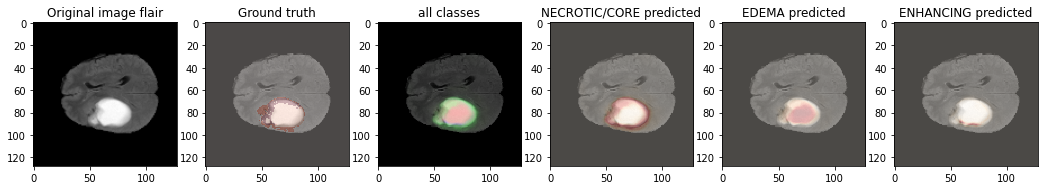

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00054/BraTS2021_00054_flair.nii.gz
4/4 [==============================] - 0s 27ms/step


<Figure size 1296x3600 with 0 Axes>

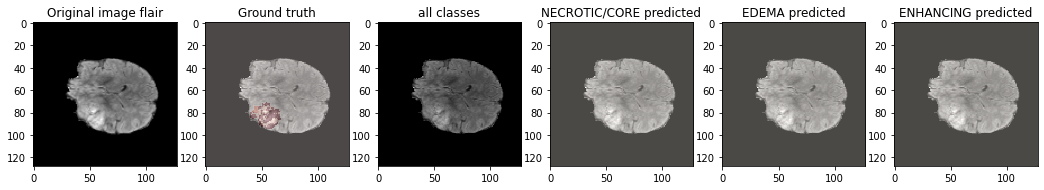

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01172/BraTS2021_01172_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

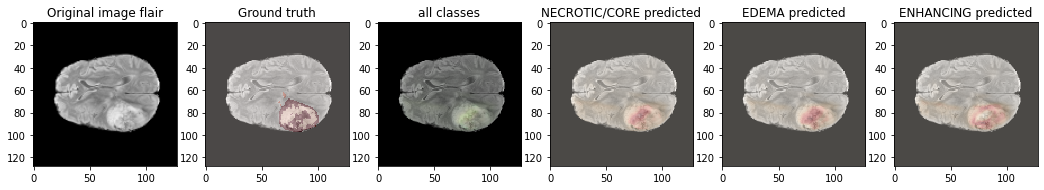

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00191/BraTS2021_00191_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

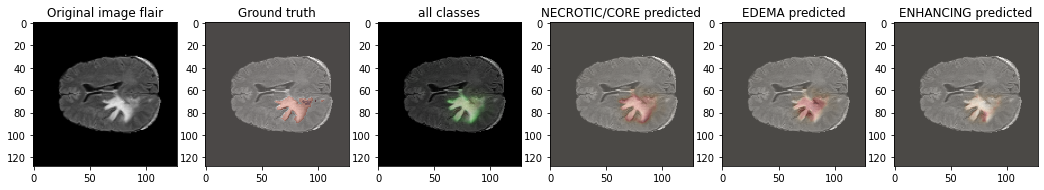

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01342/BraTS2021_01342_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

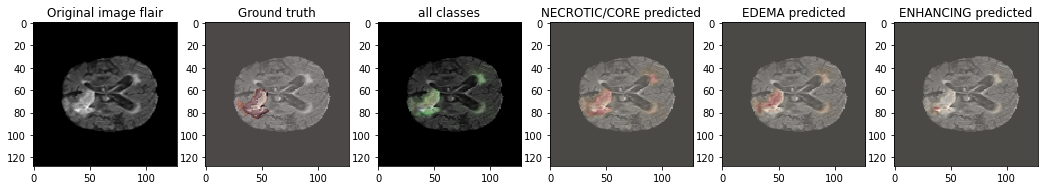

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00097/BraTS2021_00097_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

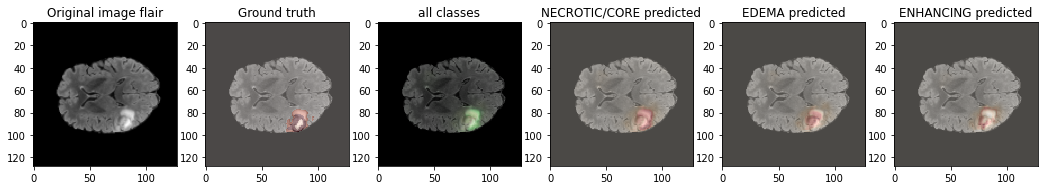

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01625/BraTS2021_01625_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

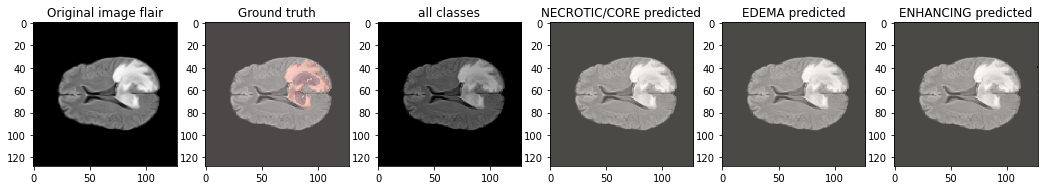

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00451/BraTS2021_00451_flair.nii.gz
4/4 [==============================] - 0s 29ms/step


<Figure size 1296x3600 with 0 Axes>

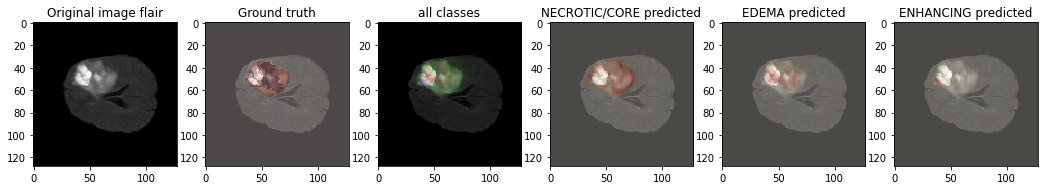

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00336/BraTS2021_00336_flair.nii.gz
4/4 [==============================] - 0s 27ms/step


<Figure size 1296x3600 with 0 Axes>

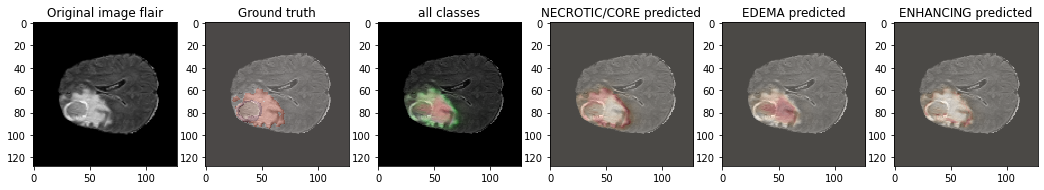

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01446/BraTS2021_01446_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

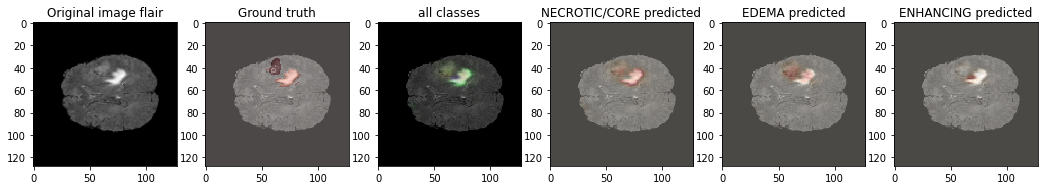

In [ ]:
###canals  2 modes
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii.gz')
    print(f'Flair image path: {vol_path_flair}')

    try:
        flair = nib.load(vol_path_flair).get_fdata()
    except FileNotFoundError:
        print(f"Error: Flair image file not found for case {case}")
        return

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    path = TRAIN_DATASET_PATH + case + '/'

    gt = nib.load(path + case + '_seg.nii.gz').get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig(f'Test_{case}.png')
    plt.show()

showPredictsById(case='BraTS2021_00124')
showPredictsById(case='BraTS2021_00054')
showPredictsById(case='BraTS2021_01172')
showPredictsById(case='BraTS2021_00191')
showPredictsById(case='BraTS2021_01342')
showPredictsById(case='BraTS2021_00097')
showPredictsById(case='BraTS2021_01625')
showPredictsById(case='BraTS2021_00451')
showPredictsById(case='BraTS2021_00336')
showPredictsById(case='BraTS2021_01446')

In [ ]:
csv_logger = CSVLogger('./evaluation_50.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
# print("test loss, test acc:", results)

In [ ]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Mean IoU:", results[2])

print("\nAdditional Metrics:")
print("Dice Coefficient:", results[3])
print("Precision:", results[4])
print("Sensitivity:", results[5])
print("Specificity:", results[6])
print("Dice Coefficient Necrotic:", results[7])
print("Dice Coefficient Edema:", results[8])
print("Dice Coefficient Enhancing:", results[9])


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import CSVLogger


csv_logger = CSVLogger('./evaluation_50.log')

model = tf.keras.models.load_model(
    'model_brats21_2D_UNet_2_modes.h5',
    custom_objects={
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_necrotic,
        'dice_coef_edema': dice_coef_edema,
        'dice_coef_enhancing': dice_coef_enhancing
    },
    compile=False
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.01),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=[csv_logger])

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Mean IoU:", results[2])

# Print additional metrics if available
if len(results) > 3:
    print("Dice Coefficient:", results[3])
    print("Precision:", results[4])
    print("Sensitivity:", results[5])
    print("Specificity:", results[6])
    print("Dice Coefficient Necrotic:", results[7])
    print("Dice Coefficient Edema:", results[8])
    print("Dice Coefficient Enhancing:", results[9])
